In [1]:
import numpy as np
import math
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy import nansum
from numpy import nanmean
from numpy.random import choice
import itertools
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx

## Bipartite network generation

### Data preparation

In [2]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')

In [3]:
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))

In [4]:
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

# Description

In [5]:
cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,269,53,3,123,116,0
Asia,34,19159,37,736,2464,6
Australia,0,55,605,62,210,1
Europe,20,745,82,23014,3904,35
North America,47,4081,331,6584,83604,57
South America,0,14,4,99,203,516


In [6]:
cb_a = cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)
cb_a["sum"] = cb_a.sum(axis = 0)
cb_a = cb_a.loc[:,"Africa":"South America"].div(cb_a["sum"], axis=0)
cb_a

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,0.727027,0.143243,0.008108,0.332432,0.313514,0.000000
Asia,0.001410,0.794748,0.001535,0.030531,0.102211,0.000249
Australia,0.000000,0.051789,0.569680,0.058380,0.197740,0.000942
Europe,0.000653,0.024332,0.002678,0.751649,0.127507,0.001143
North America,0.000519,0.045093,0.003657,0.072751,0.923791,0.000630
South America,0.000000,0.022764,0.006504,0.160976,0.330081,0.839024


<AxesSubplot:ylabel='Density'>

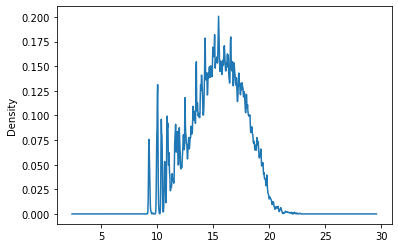

In [7]:
es1 = cb.groupby(['target_name','stage'], as_index = False).agg({"size_real": 'first'})
es2 = es1[['target_name','size_real']].groupby(['target_name'],as_index=False).sum()
es3 = es2[es2['size_real']!=0]
np.log(es3['size_real']).plot.kde(0.01)

<AxesSubplot:ylabel='Density'>

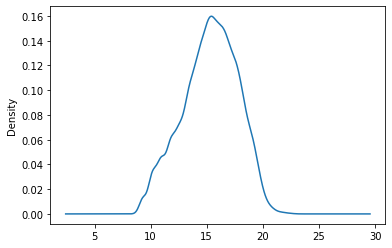

In [8]:
np.log(es3['size_real']).plot.kde()

In [12]:
cb

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
0,Shionogi & Co.,IPO,NaN,05/16/1949,Public,shionogi.com,Shionogi & Co. (TYO: 4507) focuses on the rese...,Pharmaceuticals / Drugs,Japan,Pharma Startups,IPO / Went public,262824,1878.0,IPO,Asia,NaN,Osaka,"1-8, Doshomachi 3-chome Chuo-ku…",NaN,Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
1,Astellas Pharma,IPO,NaN,05/16/1949,Public,astellas.com,Astellas Pharma (TSE: 4503) specializes in the...,Pharmaceuticals / Drugs,Japan,"Digital Therapeutics, Pharma Startups, Cancer ...",IPO / Went public,243168,1923.0,IPO,Asia,NaN,Tokyo,"2-5-1, Nihonbashi-Honcho, Chuo-ku…","Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...",Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
2,Sumitomo Dainippon Pharma,IPO,NaN,05/16/1949,Public,ds-pharma.com,Sumitomo Dainippon Pharma (TYO: 4506) is a pha...,Pharmaceuticals / Drugs,Japan,Digital Therapeutics and Pharma Startups…,IPO / Went public,447180,1897.0,IPO,Asia,NaN,Osaka,"6-8, Doshomachi 2-chome Chuo-ku…",Masayo Tada (CEO),"Astellas Pharma,Chugai Pharmaceutical,Daiichi ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
3,Konica Minolta,IPO,NaN,05/16/1949,Public,konicaminolta.com,"Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...",Medical Devices & Equipment,Japan,Conference Exhibitors,IPO / Went public,57191,1936.0,IPO,Asia,NaN,Tokyo,"JP Tower 2-7-2 Marunouchi, Chiyoda-ku…",Michael Mathé (SVP),Xerox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
4,Takeda Pharmaceutical,IPO,NaN,05/16/1949,Public,takeda.com,Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...,Pharmaceuticals / Drugs,Japan,"Poop Tech, Pharma Startups, Rare Diseases, Sle...",IPO / Went public,373007,1781.0,IPO,Asia,NaN,Tokyo,"2-1-1 Nihonbashihonmachi, Chuo-ku…","Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...","Sumitomo Dainippon Pharma,Sunovion…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187799,Beijing Shouyi,Acquired,NaN,08/17/2021,Healgen,shouyi-biochem.com…,"Beijing Shouyi is a biomedical enterprise, whi...",Medical Devices & Equipment,China,NaN,Acquired,669346,1998.0,Acquisition,Asia,Beijing,Beijing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,NaN,2021-08,2021
187800,Centaur Labs,Series A,15.89,08/17/2021,Undisclosed Investors,centaurlabs.com,Centaur Labs enables customers to build AI alg...,Internet Software & Services,United States,"Digital Health, Artificial Intelligence ( AI )...",Alive / Active,377820,2017.0,Series A,North America,Massachusetts,Boston,"883 Boylston St, Suite 200…","Erik Duhaime (CEO),Zach Rausnitz (CTO)…",Aigorithm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,15890000.0,2021-08,2021
187801,Streamline Health Solutions,IPO,NaN,08/17/2021,Public,streamlinehealth.net,Streamline Health (NASDAQ: STRM) provides solu...,Healthcare Softwa

# GRAPHS

In [324]:
nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes

,node,index,bipartite,id
0,Shionogi & Co.,262824.0,1,0
1,Astellas Pharma,243168.0,1,1
2,Sumitomo Dainippon Pharma,447180.0,1,2
3,Konica Minolta,57191.0,1,3
4,Takeda Pharmaceutical,373007.0,1,4
...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,0,83254
83255,Edvantage Group,190377.0,0,83255
83256,Healgen,NaN,0,83256


In [325]:
numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})

In [ ]:
#single id associated to a startup and associated round (for linking the investors in the same rounds, later)
id_stage = cb_new[['target_ID','stage']]
id_stage = id_stage.drop_duplicates()
id_stage.index = range(len(id_stage))
id_stage['id_stage'] = id_stage.index

In [326]:
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, id_stage,  how='left', left_on=['target_ID','stage'], right_on = ['target_ID','stage'])

In [22]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
for i in range(len(cb_new)):
    B.add_edge(cb_new.loc[i,'id_y'], cb_new.loc[i,'id_x'], date=(cb_new.loc[i,'date_y']).year, m_raised=cb_new.loc[i,'size_real'], 
               investors = cb_new.loc[i,'investor_numbers'], round_simp =cb_new.loc[i,'round_simp'])

In [23]:
bad = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(bad)

In [26]:
bid_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
org_nodes = set(B) - bid_nodes

# NEW GRAPHS

## BIDBID - directed

In [ ]:
##this code links an investor to another if one invests in the same startup in a later stage than the other
##BIDBID = bidders-bidders
links = []
subcb = cb_new[['stage','date_my','id_y','size_real','investor_numbers','target_name']].drop_duplicates()
subcb = subcb[pd.notna(subcb['date_my'])]
subcb = subcb[pd.notna(subcb['size_real'])]
for i in tqdm(subcb['target_name'].unique()):
    subcb2 = subcb[subcb['target_name']==i]
    for date1 in (subcb2['date_my']).unique():
        for date2 in (subcb2['date_my']).unique():
            if date2>date1:
                list1 = list(subcb2[subcb2['date_my']==date1]['id_y'])
                list2 = list(subcb2[subcb2['date_my']==date2]['id_y'])
                for couple in itertools.product(list2, list1):
                    inter = subcb2[subcb2['date_my']==date2]
                    links.append((couple + ({'money': inter['size_real'].values[0]/inter['investor_numbers'].values[0],
                             'date': date2.year,
                             'stage': inter['stage'].values[0],
                             'target_name':i},)))


## BIDBID - Undirected

In [ ]:
##this is to link investors if they have invested in the same startup in the same round
links = []
subcb = cb_new[['stage','date_y','id_y','size_real','id_stage','investor_numbers','target_name']].drop_duplicates()
subcb = subcb[pd.notna(subcb['date_y'])]
subcb = subcb[pd.notna(subcb['size_real'])]
for i in tqdm(subcb['id_stage'].unique()):
    subcb2 = subcb[subcb['id_stage']==i]
    for couple in itertools.combinations(np.unique(subcb2['id_y'].values),2):
        links.append((couple + ({'date': subcb2['date_y'].values[0].year,
                                'stage': subcb2['stage'].values[0],
                                'money': subcb2['size_real'].values[0]/(subcb2['investor_numbers'].values[0]-1),
                                'target_name': subcb2['target_name'].values[0]},)))
#----------------------
bidbid_stage=nx.MultiGraph()
bidbid_stage.add_nodes_from(nodes[nodes.bipartite==0].id)
nx.set_node_attributes(bidbid_stage, pd.Series(nodes_inv.node, index=nodes_inv.id).to_dict(), 'name')
nx.set_node_attributes(bidbid_stage, pd.Series(nodes_inv.country, index=nodes_inv.id).to_dict(), 'country')
nx.set_node_attributes(bidbid_stage, pd.Series(nodes_inv.continent, index=nodes_inv.id).to_dict(), 'continent')
nx.set_node_attributes(bidbid_stage, pd.Series(nodes_inv.industry, index=nodes_inv.id).to_dict(), 'industry')
nx.set_node_attributes(bidbid_stage, pd.Series(nodes_inv.foundation, index=nodes_inv.id).to_dict(), 'foundation')
nx.set_node_attributes(bidbid_stage, pd.Series(nodes_inv.bipartite, index=nodes_inv.id).to_dict(), 'bipartite')
bidbid_stage.add_edges_from(links) 

## ORGORG - Undirected

In [ ]:
#this code is used to connect startups if they have raised money by the same investor at a maximum distance of 10 years
#this is a projection of the bipartite graph B
count=0
for year in range(1979,2022):
    locals()["orgorg_"+str(year)] = nx.MultiGraph()
for node in tqdm(bid_nodes):
    ego=nx.ego_graph(B, node)
    ndx=list(ego.nodes())
    ndx.remove(node)
    finestra = window(list(range(1970,2022)), 10)
    for periodo in finestra: # bad trick to link depending on year
        subndx=[x for x in ndx if [y for y in list(ego.edges(data=True)) if y[0]==x or y[1]==x][0][2]['date'] in periodo]
        for couple in itertools.combinations(subndx, 2):
            anno1 = ego[node][couple[0]][0]['date']
            anno2 = ego[node][couple[1]][0]['date']
            locals()["orgorg_"+str(periodo[-1])].add_edge(couple[0], couple[1], anno = max(anno1,anno2))
    count+=1
    if count%1000==0:
        print(count, end=' ')